In [2]:
import numpy as np, xarray as xr, matplotlib.pyplot as plt, pandas as pd, s3fs, xesmf, time, pandas as pd, matplotlib as mpl
from utils import *
import dask.array as da
from dask.diagnostics import ProgressBar
from dask.distributed import Client, LocalCluster
import cartopy.crs as ccrs
from datetime import datetime
from ipywidgets import interact, interactive, fixed, interact_manual, widgets
import cmaps
%load_ext autoreload
%autoreload 2

s3 = s3fs.S3FileSystem(key="K1CQ7M1DMTLUFK182APD", secret="3JuZAQm5I03jtpijCpHOdkAsJDNLNfZxBpM15Pi0", 
                       client_kwargs=dict(endpoint_url="https://rgw.met.no"))

In [26]:
client.close()

In [22]:
cluster = LocalCluster(n_workers=8, memory_limit='20GB') #16 is best (matches number of cores)
client = Client(cluster)

/srv/conda/envs/notebook/lib/python3.9/site-packages/distributed/node.py:183: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 34007 instead
  warnings.warn(
2022-11-06 15:10:17,434 - distributed.nanny - WARNING - Worker process still alive after 3.1999986267089846 seconds, killing
2022-11-06 15:10:17,435 - distributed.nanny - WARNING - Worker process still alive after 3.199999389648438 seconds, killing
2022-11-06 15:10:17,438 - distributed.nanny - WARNING - Worker process still alive after 3.1999981689453127 seconds, killing
2022-11-06 15:10:17,442 - distributed.nanny - WARNING - Worker process still alive after 3.1999981689453127 seconds, killing
2022-11-06 15:10:17,449 - distributed.nanny - WARNING - Worker process still alive after 3.1999987792968754 seconds, killing
2022-11-06 15:10:17,453 - distributed.nanny - WARNING - Worker process still alive after 3.1999989318847657 seconds, killing
2022-11-06 15:10:17,460 

In [44]:
#tosBS = clip_to_region(get_bucket_data('tos', thing='Omon', model='NorESM2-LM', experiment='historical'))
#SI = clip_to_region(get_bucket_data('siconc', thing='SImon', model='NorESM2-LM', experiment='historical'))

# Temperature

In [ ]:
tos_anomaly = time_anomaly(tosBS, 0, 12*30, -12*30, -1)
tos_anomaly.plot()

In [ ]:
tosBSmean = regional_average(tosBS.tos.isel(time=slice(-12*70, -1)), model='NorESM2-LM')
tosBSmean.isel(time=slice(-12*50, -1)).plot(x='time')

# Sea Ice

In [ ]:
SImean = regional_average(SI, model='NorESM-LM')

SIMarch = SI.groupby('time.month')[3]
SIMarchSpatialMean = regional_average(SIMarch, areacello.areacello)

SISeptember = SI.groupby('time.month')[9]
SISeptemberSpatialMean = regional_average(SISeptember, areacello.areacello)

In [ ]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(12,8))

SIMarchSpatialMean.isel(time=slice(-12*65, -1)).plot(ax=ax[0,0])
SISeptemberSpatialMean.isel(time=slice(-12*65, -1)).plot(ax=ax[0,1])

time_anomaly(SIMarch, 0, 12*30, -12*30, -1).plot(ax=ax[1,0])
time_anomaly(SISeptember, 0, 12*30, -12*30, -1).plot(ax=ax[1,1])

plt.show()

In [ ]:
SImeanMarch = SImean.groupby('time.month')[3]
SImeanSeptember = SImean.groupby('time.month')[9]
SImeanMarch.plot()
SImeanSeptember.plot()

# Chlorofyll

In [20]:
# NOT NEEDED ANYMORE! ALL DAILY CHLOS READ TO FILE FOR BARENTS (april-september) Takes 15 mins to read all in if not
start = time.time()
chlos = get_bucket_data('chlos', time_res='daily', thing='Oday', experiment='historical')
print(time.time() - start)

Request: s3://escience2022/Ada/daily/chlos_Oday_NorESM2-LM_historical_*.nc
937.0183291435242


In [ ]:
chlos_clipped = clip_to_months(clip_to_region(chlos, minlat=65, minlon=0, maxlon=70), 4, 9)
chlos_clipped.chlos.to_netcdf('chlos_NorESM2-LM_historical_all_.nc')

/srv/conda/envs/notebook/lib/python3.9/site-packages/xarray/core/indexing.py:1380: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]


In [3]:
chlos_daily = xr.open_dataset('chlos_NorESM2-LM_historical_all') # Daily NorESM2 output of chlorophyll

In [17]:
chlos_mon_sat = clip_to_region(xr.load_dataset('OBS-ESACCI-OC.nc')) # Monthly satellite observation of Chlorophyll

In [18]:
slider_map(chlos_mon_sat.chl, datetime(1997, 10, 1), datetime(2017, 10, 1))

interactive(children=(SelectionSlider(description='date', layout=Layout(width='800px'), options=(('1997-10', T…

In [4]:
chlos_daily

<xarray.Dataset>
Dimensions:    (time: 60225, j: 385, i: 360)
Coordinates:
  * time       (time) object 1850-01-01 12:00:00 ... 2014-12-31 12:00:00
  * j          (j) int32 1 2 3 4 5 6 7 8 9 ... 378 379 380 381 382 383 384 385
  * i          (i) int32 1 2 3 4 5 6 7 8 9 ... 353 354 355 356 357 358 359 360
    latitude   (j, i) float64 ...
    longitude  (j, i) float64 ...
Data variables:
    chlos      (time, j, i) float32 ...

In [7]:
chlos_daily_mean = regional_average(chlos_daily)
peak_dates = find_peak_dates(chlos_daily_mean.chlos)

Found local areacello NetCDF


In [12]:
chlos_daily_anomaly = time_anomaly(chlos_daily.chlos, 0, 365*30, -365*30, -1)

In [13]:
chlos_daily_anomaly

<xarray.DataArray 'chlos' (j: 385, i: 360)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * j          (j) int32 1 2 3 4 5 6 7 8 9 ... 378 379 380 381 382 383 384 385
  * i          (i) int32 1 2 3 4 5 6 7 8 9 ... 353 354 355 356 357 358 359 360
    latitude   (j, i) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    longitude  (j, i) float64 nan nan nan nan nan nan ... nan nan nan nan nan

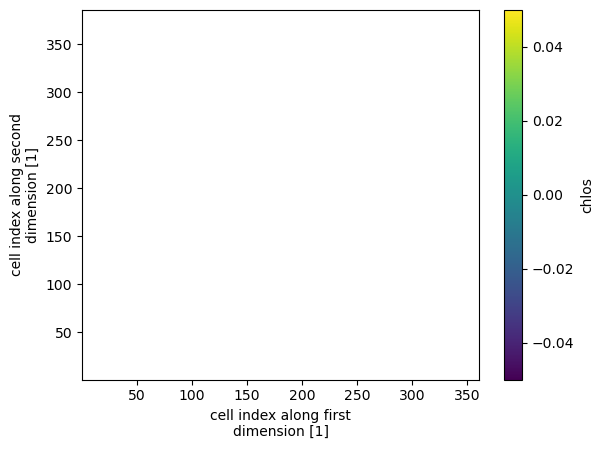

In [15]:
chlos_daily_anomaly.plot()

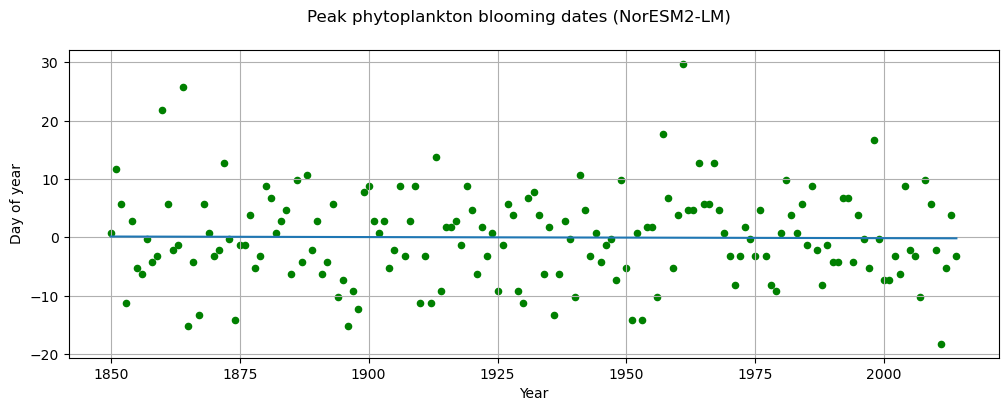

In [97]:
scatter_dates(peak_dates, last_n_years=0)

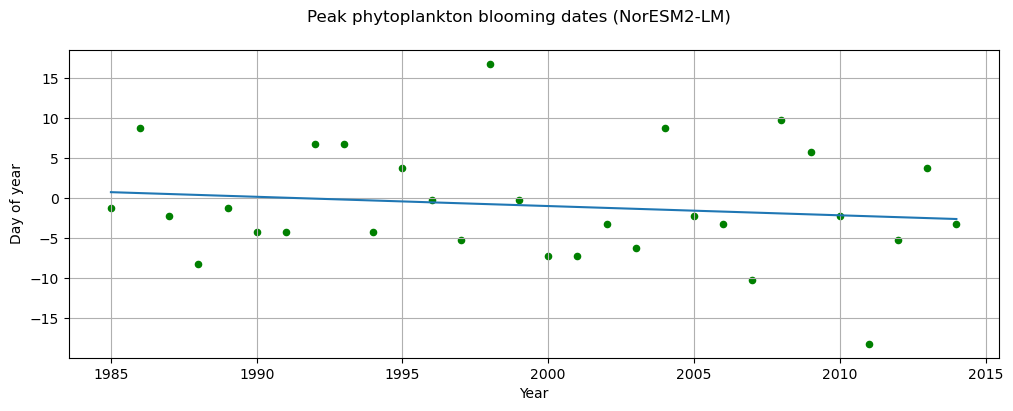

In [98]:
scatter_dates(peak_dates, last_n_years=30)

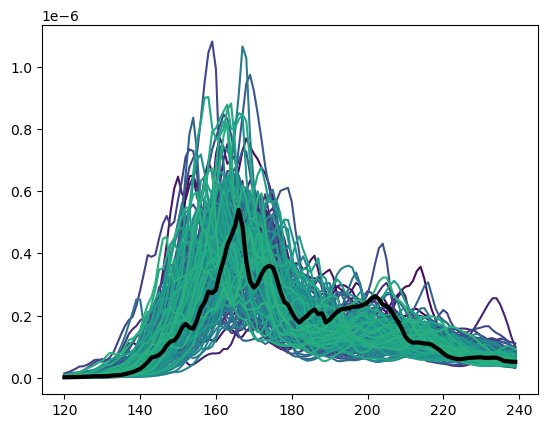

In [89]:
fig, ax = plt.subplots()
#average_yearly_cycle = chlos_daily_mean.chlos.groupby('time.dayofyear').mean()

cmap = plt.cm.viridis
cmaplist = [cmap(i) for i in range(cmap.N)]
cmaplist = cmaplist[::int(cmap.N/165)]
#cmap = mpl.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, cmap.N)

# define the bins and normalize
bounds = np.arange(1850, 2015)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

chlos_daily_mean_grouped = chlos_daily_mean.chlos.groupby('time.year')
[ax.plot(np.arange(120, 120+30*4), chlos_daily_mean_grouped[year].isel(time=slice(120, 120+30*4)), color=cmaplist[year-1850]) for year in range(1850, 2014)]

ax.plot(np.arange(120, 120+30*4), chlos_daily_mean.chlos.isel(time=slice(120, 120+30*4)), linewidth=3, color='k')
#ax.legend()
plt.show()

Do we see a shift in the peak phytoplankton blooming date in the Barentz sea in connection to the sea ice retreat?

In [11]:
start = time.time()
with ProgressBar():
    chlos_daily_mean.compute()
print(time.time() - start)

0.027305126190185547


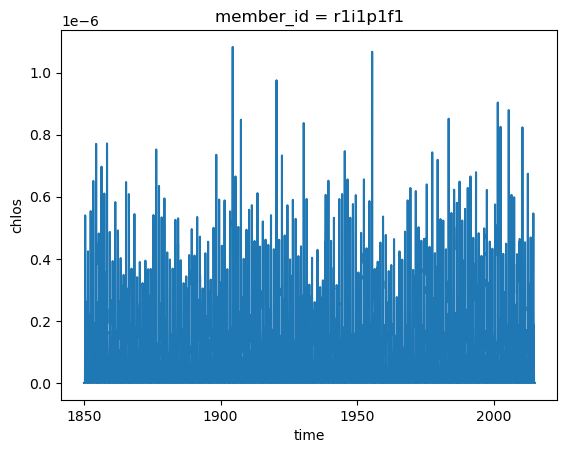

In [18]:
chlos_daily_mean.chlos.plot()

månedlig noresm chlos for å se peak, plotte oppå /OBS-ESACCI-OC/

For NorESM2 chlorophyll, time by 10 to get total mass when integrating for surface layer